# AI model trainning: can a machine differnciate question/non-question with only textual context?
1. Load the dataset

In [1]:
import pandas as pd
import ast

# Load full dataset
df = pd.read_csv("N_1000_filtered_train_data_with_features.csv")

# Define labels that are questions
question_labels = {'yn', 'wh', 'imp'}

# Sample with all columns preserved
yn_df = df[df['label'] == 'yn']
wh_df = df[df['label'] == 'wh'].sample(n=min(100, len(df[df['label'] == 'wh'])), random_state=42)
imp_df = df[df['label'] == 'imp'].sample(n=min(100, len(df[df['label'] == 'imp'])), random_state=42)
nq_df = df[df['label'] == 'nq'].sample(n=295, random_state=42)

# Combine them
balanced_df = pd.concat([yn_df, wh_df, imp_df, nq_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Assign binary label: question (1) vs. not-question (0)
balanced_df['binary_label'] = balanced_df['label'].apply(lambda x: 1 if x in question_labels else 0)

# Parse MFCCs
balanced_df['mfcc_means'] = balanced_df['mfcc_means'].apply(ast.literal_eval)

# Check counts
print(balanced_df['binary_label'].value_counts())

binary_label
0    295
1    295
Name: count, dtype: int64


2. Organize all data to prepare for AI training (only text)

In [2]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Vectorize text
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(balanced_df['text'])

# 2. Use text features directly as X
X = text_features

# 3. Labels
y = balanced_df['binary_label']

3.1 Model training (Logistical regression)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86        59
           1       0.83      0.92      0.87        59

    accuracy                           0.86       118
   macro avg       0.87      0.86      0.86       118
weighted avg       0.87      0.86      0.86       118

Confusion Matrix:
 [[48 11]
 [ 5 54]]


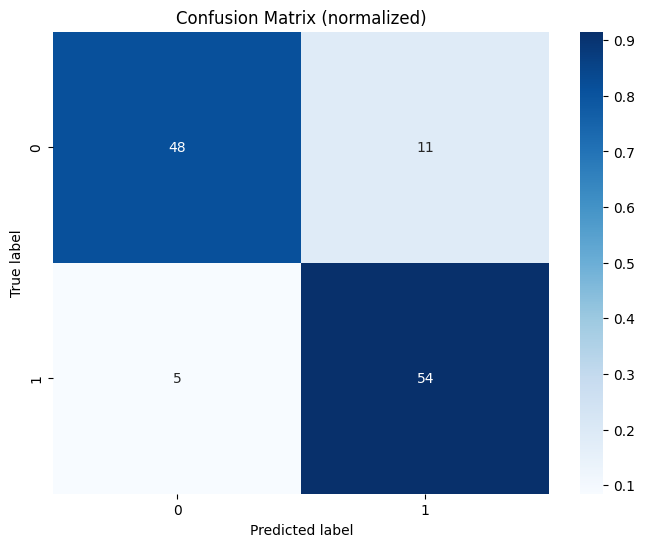

In [21]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# 5. Train the model using logistic regression
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 7. Visualize the confusion matrix with seaborn
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,               # Normalized confusion matrix
    annot=cm,              # Show raw counts in the boxes
    fmt='d',               # Integer format for counts
    cmap='Blues',          # Colormap
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Confusion Matrix (normalized)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()